This notebooks generates numerous time series (r, v) from the Montbrio equations that will be used for the time delay embedding regression (to recover r when only v and the generating model are known).
The time series are generated according to a set of randomly chosen values parameters, yielding different parameter regimes. 

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp
import scipy as scp
import matplotlib.pyplot as plt

import re
import pandas as pd
import seaborn as sns

In [2]:
from scipy import stats as spstats
from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
import numba
from numba import jit

In [4]:
import cmdstanpy

In [5]:
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [6]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [7]:
import warnings
warnings.simplefilter("ignore")

In [8]:
print('Running on numpy: v{}'.format(np.version.version))
#print('Running on torch: v{}'.format(torch.__version__))
#print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v1.23.0


In [9]:
cwd = os.getcwd()
cwd

'/home/tng/Documents/montbrio/time_delay'

In [10]:
Res_dir='Res_syntheticData' 
!mkdir -p $Res_dir

In [11]:
SEED = 0

In [12]:
from numba import njit
@njit
def set_seed(value):
    np.random.seed(value)

# Simulation of Montbrio model


$\dfrac{dr}{dt} = 2rv +\Delta/\pi$

$ \dfrac{dv}{dt} = v^2  -\pi^2 r^2 + Jr+ \eta +I(t) $


In [13]:
def Montbrio_SDEmodel(params, constants, I_input, sigma, dt, ts):
   
    delta, alpha, beta  = params[0], params[1], params[2]
    
    eta=alpha*delta
    J=beta*np.sqrt(delta)

    # simulation from initial point
    v = np.zeros_like(ts)  # fast voltage
    r = np.zeros_like(ts)  # slow voltage

    # fixed parameters
    v_init, r_init=constants[0], constants[1]
    
    dt = float(dt)

    v[0],r[0]= v_init, r_init
        
    for i in range(1, ts.shape[0]):
        dr =(delta/np.pi) +2.*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        v[i]=v[i-1] + dt * dv + np.sqrt(dt) * sigma * np.random.randn() 
        r[i]=r[i-1] + dt * dr + np.sqrt(dt) * sigma * np.random.randn() 
        
    return np.concatenate((np.array(v).reshape(-1), np.array(r).reshape(-1),))

In [14]:
Montbrio_SDEmodel_numba = numba.jit(Montbrio_SDEmodel)

## 1. Simulator


In [15]:
def Montbrio_SDEmodel_Wrapper(model_params, sim_params, input_type='uniform'):

    params = np.asarray(model_params)
    
    t_init = sim_params['t_init']
    t_final = sim_params['t_final']

    dt = sim_params['dt']
    ts = np.arange(t_init, t_final, dt)
    sigma = sim_params['sigma']
    nIsteps = int((t_final - t_init)/dt)

    I0=sim_params['I0']
    t_on=sim_params['t_on']
    t_off=sim_params['t_off']

    I_input=[]
    if input_type == 'sin' :
        I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 * np.sin(i/318) for i in range(int((t_off - t_on)/dt))] + [0 for i in range(int((t_final - t_off)/dt))]
    else :
        I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    
    I_input =np.asarray(I_input)
    
    v0 = sim_params['v0']
    r0 = sim_params['r0']
    
    constants=[v0, r0]
    
    rv = Montbrio_SDEmodel_numba(params, constants, I_input, sigma, dt, ts)

    return rv.reshape(-1), I_input  


In [16]:
t_init = 0.0
t_final = 100.0
dt = 0.01
sigma = 0.1
I0 = 3.
t_on = 30.
t_off = 60.
v0 = -3.0
r0 = 0.5
sim_params={'t_init': t_init, 't_final': t_final, 'dt': dt, 'sigma': sigma,
            'I0': I0, 't_on': t_on, 't_off': t_off, 'r0': r0, 'v0': v0}

params_label=np.array(['delta', 'alpha', 'beta'])
params_label=np.array(['$\Delta$', '$alpha$', '$beta$'])

# Example with 10 simulations

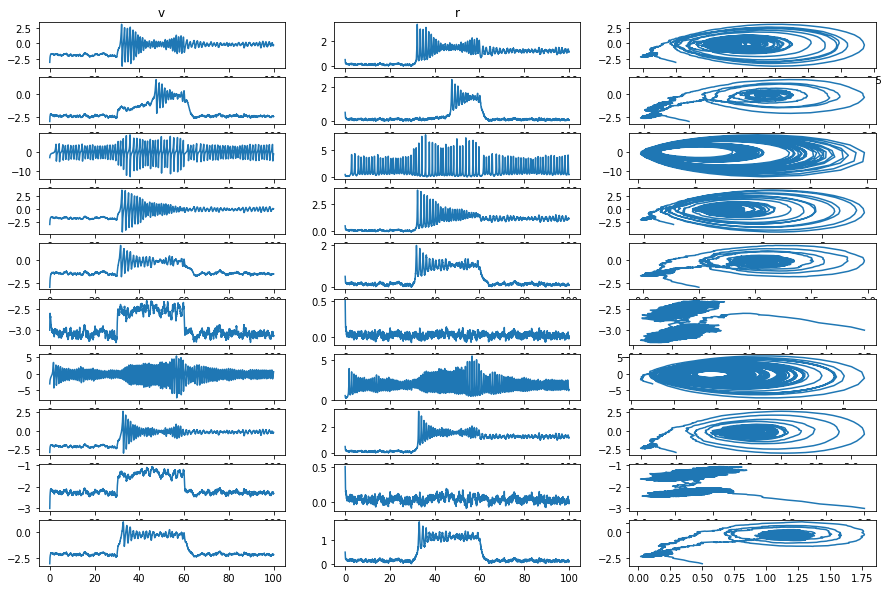

In [17]:
N_sims = 10

fig, ax = plt.subplots(nrows=N_sims, ncols=3, figsize=(15, 10))

np.random.seed(0)
for i in range(N_sims) :
    
    delta_true=np.random.uniform(0.2, 2)
    eta_true=np.random.uniform(-10, -3)
    J_true=np.random.uniform(10, 20)

    alpha_true=eta_true/delta_true
    beta_true=J_true/np.sqrt(delta_true)
    true_params = np.array([delta_true, alpha_true, beta_true])
    set_seed(1)
    y_obs, I_input=Montbrio_SDEmodel_Wrapper(model_params=true_params, 
                                             sim_params=sim_params,
                                             input_type='uniform')
    
    vs=y_obs[0:int(y_obs.shape[0]/2)]
    rs=y_obs[int(y_obs.shape[0]/2): int(y_obs.shape[0])]

    ts = np.arange(t_init, t_final, dt)
    
    ax[i, 0].plot(ts, vs)
    ax[i, 1].plot(ts, rs)
    ax[i, 2].plot(rs, vs)
    ax[0, 0].set(title='v')
    ax[0, 1].set(title='r')

# More simulations that will be used for the time delay embedding regression to recover r from knowing only v

In [18]:
data_input_dict= {
    'nt': ts.shape[0], 'ts': ts, 'dt': dt, 't0': t_init, 't_final': t_final,  'I0': I0, 't_on': t_on, 
    't_off': t_off, 'I_input': I_input, 'sigma': sigma, 'r_init': r0, 'v_init': v0, 
    'rlim': np.r_[0.0, 8.0],'vlim': np.r_[-8.0, 8.0],
    }

In [19]:
N_sims = 100

In [20]:
np.random.seed(0)

! mkdir -p $Res_dir/data_input_files/multiple

for i in range(N_sims) :
    
    delta_true=np.random.uniform(0.2, 2)
    eta_true=np.random.uniform(-10, -3)
    J_true=np.random.uniform(10, 20)
    alpha_true=eta_true/delta_true
    beta_true=J_true/np.sqrt(delta_true)
    true_params = np.array([delta_true, alpha_true, beta_true])
    
    set_seed(1)
    y_obs, I_input=Montbrio_SDEmodel_Wrapper(model_params=true_params, 
                                             sim_params=sim_params,
                                             input_type='uniform')
    
    vs=y_obs[0:int(y_obs.shape[0]/2)]
    rs=y_obs[int(y_obs.shape[0]/2): int(y_obs.shape[0])]

    ts = np.arange(t_init, t_final, dt)
    
    data_input_filename=str('data_input_' + str(i))
    i_dict = {'vs': vs, 'rs': rs, 'delta_true': delta_true, 'eta_true': eta_true, 'J_true': J_true,
             'alpha_true': eta_true/delta_true, 'beta_true': J_true/np.sqrt(delta_true)}
    simul_i_dict = {**data_input_dict, **i_dict}
    
    nd=[]
    npz = {'nd': nd}
    npz.update(simul_i_dict)
    np.savez(cwd+'/'+Res_dir+'/data_input_files/multiple/'+data_input_filename+'.R.npz', **npz)
    np.savez(cwd+'/'+Res_dir+'/data_input_files/multiple/'+data_input_filename+'.npz', **npz)
    cmdstanpy.write_stan_json(cwd+'/'+Res_dir+'/data_input_files/multiple/'+data_input_filename+'.json',
                              simul_i_dict)